# Course project

This notebook includes the code for the course project in the DTU course [Integrated Energy Grids](https://kurser.dtu.dk/course/2024-2025/46770?menulanguage=en)  and is modelling and analyzing the german energy system. 
 
The report is provided along this notebook, further explaining the results. 

### Imports

In [130]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np

### Functions

In [131]:
def annuity(r, n):
    return r / (1 - 1 / (1 + r)**n) if r > 0 else 1 / n

## A. Optimal capacities for selected country 
Choose a different country/region/city/system and calculate the optimal capacities for renewable and non-renewable generators. You can add as many technologies as you want. Remember to provide a reference for the cost assumptions. Plot the dispatch time series for a week in summer and winter. Plot the annual electricity mix. Use the duration curves or the capacity factor to investigate the contribution of different technologies.

/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/ipykernel_42309/3444582115.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  network.set_snapshots(pd.date_range(f"{year}-01-01", f"{year}-12-31 23:00", freq="H"))


<Axes: xlabel='snapshot', ylabel='MW'>

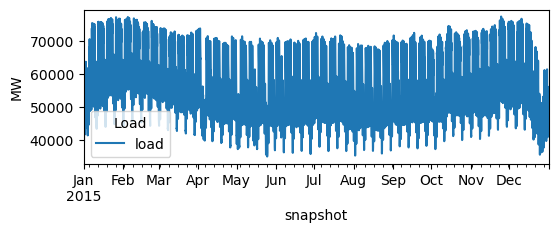

In [132]:
# 1. Create the network
network = pypsa.Network()

# 2. Set the modeling year
year = 2015
network.set_snapshots(pd.date_range(f"{year}-01-01", f"{year}-12-31 23:00", freq="H"))

network.add("Bus",
      "electricity")

# 3. Select country
country = "DEU"  # Germany

# 4. Add one electricity bus
network.add("Bus", name="electricity")

# 5. Load demand time series
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='DEU'

# 6. Add demand as a load to the bus
network.add("Load",
            name="load",
            bus="electricity",
            p_set=df_elec[country].values)

network.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

In [133]:
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_offhorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offhorewind.index = pd.to_datetime(df_offhorewind.index)

df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

In [134]:
CF_onwind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_offwind = df_offhorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

In [135]:
carriers = [
    "solar",
    "onwind",
    "offwind",
    "offwind-float",
    "OCGT",
    "CCGT",
    "hydro",
    "ror",
    "battery storage",
    "battery inverter",
    #"Lithium-Ion-NMC-store",
    #"Lithium-Ion-NMC-bicharger",
    "coal",
    "lignite",
    #"gas CHP",
    "waste CHP",
    "biomass CHP",
    "central gas CHP",
#    "nuclear"
]

country='DEU'

carriers = [
    "onwind",
    "offwind",
    "solar",
    "OCGT",
    "CCGT",
    #"hydro",
    #"ror",
    #"coal",
    #"lignite",
    #"biomass CHP",
    #"battery storage",
]

In [136]:
costs = pd.read_csv("data/costs_2025.csv", index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

costs["marginal_cost"] = costs["VOM"] + (costs["fuel"] / costs["efficiency"])
annuity_results = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity_results + (costs["FOM"] / 100)) * costs["investment"]

costs = costs.loc[costs.index.get_level_values(0).isin(
    ["onwind",
     "offwind",
    "solar",
    "OCGT",
    "CCGT",
    "hydro",
    "ror",
    "coal",
    "lignite",
    "biomass CHP",
    "battery storage",
])]

costs[["CO2 intensity", 'efficiency', 'investment', 'lifetime', "FOM", "VOM", "marginal_cost", "capital_cost"]]

parameter,CO2 intensity,efficiency,investment,lifetime,FOM,VOM,marginal_cost,capital_cost
technology,,,,,,,,
CCGT,0.1980,0.5700,904779.5,25.0,3.3392,4.5504,47.652154,107851.993930
OCGT,0.1980,0.4050,470485.3,25.0,1.7784,4.7620,65.423728,48739.697513
battery storage,0.0000,1.0000,197887.4,22.5,0.0000,0.0000,0.000000,17718.354182
biomass CHP,0.0000,0.2998,3487660.5,25.0,3.5955,2.2255,2.225500,424676.784673
coal,0.3361,0.3560,3827162.9,40.0,1.3100,3.2612,30.098840,337208.027448
hydro,0.0000,0.9000,2274817.7,80.0,1.0000,0.0000,0.000000,182698.734592
lignite,0.4069,0.3300,3827162.9,40.0,1.3100,3.2612,13.256655,337208.027448
offwind,0.0000,1.0000,1769117.1,30.0,2.3741,0.0212,0.021200,184567.393550
onwind,0.0000,1.0000,1139882.6,28.5,1.2347,1.5080,1.508000,107441.457021


In [137]:
network.add(
    "Carrier",
    carriers,
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'CCGT'], dtype='object')

In [138]:
## Renewables
# add onshore wind generator
network.add("Generator",
            "onshorewind",
            bus="electricity",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["onwind", "capital_cost"],
            marginal_cost = costs.at["onwind", "marginal_cost"],
            p_max_pu = CF_onwind.values)

# add solar
network.add("Generator",
            "solar",
            bus="electricity",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["solar", "capital_cost"],
            marginal_cost = costs.at["solar", "marginal_cost"],
            p_max_pu = CF_solar.values)


## conventional
# add OCGT (Open Cycle Gas Turbine) generator
network.add("Generator",
            "OCGT",
            bus="electricity",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = costs.at["OCGT", "capital_cost"],
            marginal_cost = costs.at["OCGT", "marginal_cost"])

# add offshore wind generator
network.add("Generator",
            "offshorewind",
            bus="electricity",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["offwind", "capital_cost"],
            marginal_cost = costs.at["offwind", "marginal_cost"],
            p_max_pu = CF_offwind.values)

network.add(
            "Generator",
            "coal",
            bus="electricity",
            carrier="coal",
            capital_cost=costs.at["coal", "capital_cost"],
            marginal_cost=costs.at["coal", "marginal_cost"],
            efficiency=costs.at["coal", "efficiency"],
            p_nom_extendable=True)



Index(['coal'], dtype='object')

<Axes: xlabel='snapshot', ylabel='CF'>

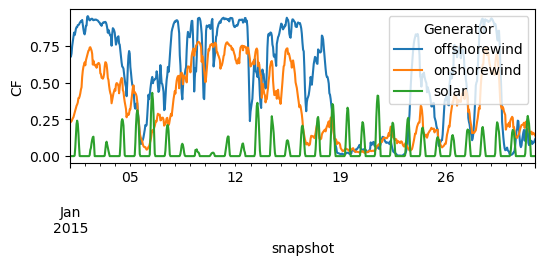

In [139]:
network.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

In [140]:
network.optimize(solver_name="highs")

Index(['onshorewind', 'OCGT', 'offshorewind', 'coal'], dtype='object', name='Generator')
Index(['electricity'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
INFO:linopy.io: Writing time: 0.58s


Running HiGHS 1.9.0 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+00]
  Cost   [1e-02, 3e+05]
  Bound  [0e+00, 0e+00]
  RHS    [4e+04, 8e+04]
Presolving model
48312 rows, 39557 cols, 118656 nonzeros  0s
48312 rows, 39557 cols, 118656 nonzeros  0s
Presolve : Reductions: rows 48312(-48053); columns 39557(-4248); elements 118656(-52301)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(3.7072e+09) 0s
      40308     3.5403854737e+10 Pr: 0(0) 4s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-z8bpft0o
Model status        : Optimal
Simplex   iterations: 40308
Objective value     :  3.5403854737e+10
Relative P-D gap    :  1.7239692317e-14
HiGHS run time      :          3.65


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 3.54e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Writing the solution to /private/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/linopy-solve-gkfm43el.sol


('ok', 'optimal')

In [141]:
print(f"System cost: {round(network.objective / 1e9, 2)} billion euros")
print("")
print("Optimal Generator Capactities in GW:")
print(network.generators.p_nom_opt.div(1e3))  # MW -> GW
print("")
print("Optimal Energy Generation in GWh/a")
print(network.generators_t.p.sum().div(1e6))

System cost: 35.4 billion euros

Optimal Generator Capactities in GW:
Generator
onshorewind      6.121622
solar           51.647278
OCGT            68.901836
offshorewind    48.299950
coal             6.247100
Name: p_nom_opt, dtype: float64

Optimal Energy Generation in GWh/a
Generator
onshorewind      10.827899
solar            53.254696
OCGT            237.132643
offshorewind    151.795176
coal             52.254149
dtype: float64


In [142]:
print(network.generators_t.p.columns.tolist())


['onshorewind', 'solar', 'OCGT', 'offshorewind', 'coal']


In [143]:
color_map = {
    "solar": "#f9d002",          # yellow
    "onshorewind": "#1f78b4",         # blue
    "offshorewind": "#6baed6",        # light blue
    "OCGT": "#e31a1c",           # red
    "CCGT": "#fb9a99",           # salmon
    "coal": "#8c564b",           # brown
    "lignite": "#7f3b08",        # dark brown
    "hydro": "#3182bd",          # medium blue
    "ror": "#9ecae1",            # light blue
    "biomass CHP": "#33a02c",    # green
    "waste CHP": "#ff7f00",      # orange
    "central gas CHP": "#a6cee3",# soft blue
    "battery storage": "#6a3d9a",# purple
    "battery inverter": "#b2df8a" # light green
}


In [144]:
network.generators_t.p.loc["2015-01-15":"2015-01-21"]

Generator,onshorewind,solar,OCGT,offshorewind,coal
snapshot,,,,,
2015-01-15 00:00:00,2173.175676,-0.0,2070.667862,42359.056532,6247.099930
2015-01-15 01:00:00,2436.405405,-0.0,-0.000000,43469.955392,6019.639202
2015-01-15 02:00:00,2748.608108,-0.0,37.536371,43276.755591,6247.099930
2015-01-15 03:00:00,3079.175676,-0.0,1642.367912,42407.356483,6247.099930
2015-01-15 04:00:00,3446.472973,-0.0,5249.169772,41586.257325,6247.099930
...,...,...,...,...,...
2015-01-21 19:00:00,648.891892,-0.0,57200.714671,6327.293507,6247.099930
2015-01-21 20:00:00,734.594595,-0.0,53769.311919,6278.993557,6247.099930
2015-01-21 21:00:00,759.081081,-0.0,51326.524986,5844.294003,6247.099930


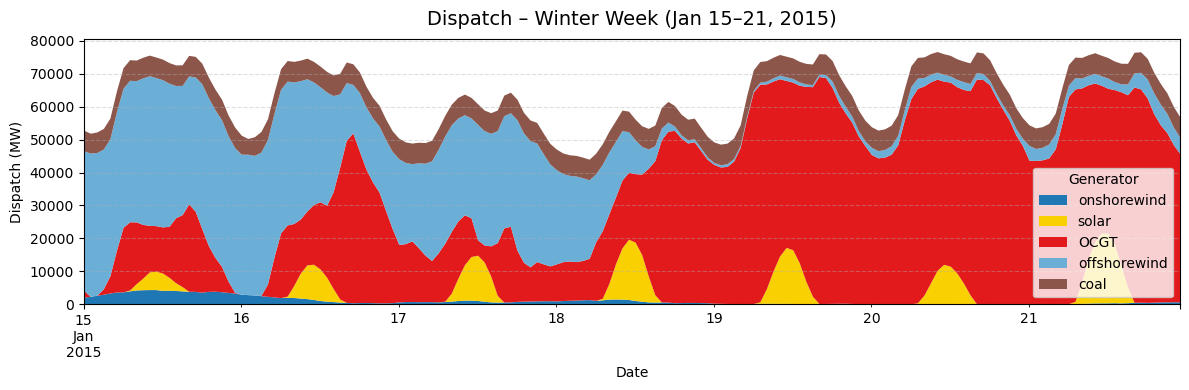

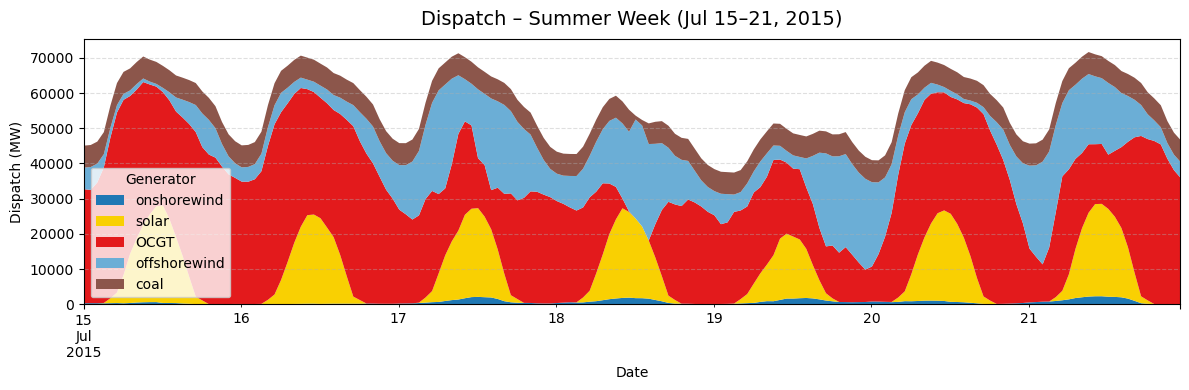

In [145]:
# Function to plot a week with consistent color mapping
def plot_dispatch_week(start, end, title):
    week = network.generators_t.p.loc[start:end]
    colors = [color_map.get(gen, "#999999") for gen in week.columns]

    fig, ax = plt.subplots(figsize=(12, 4))
    week.plot.area(ax=ax, linewidth=0, color=colors)

    ax.set_title(title, fontsize=14, pad=10)
    ax.set_ylabel("Dispatch (MW)")
    ax.set_xlabel("Date")

    plt.subplots_adjust(top=0.75)

    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# Plot winter week
plot_dispatch_week("2015-01-15", "2015-01-21", "Dispatch – Winter Week (Jan 15–21, 2015)")

# Plot summer week
plot_dispatch_week("2015-07-15", "2015-07-21", "Dispatch – Summer Week (Jul 15–21, 2015)")

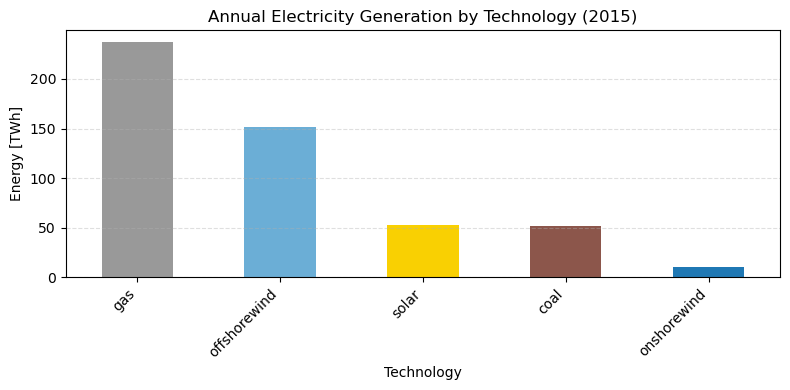

In [146]:
# Total energy generation (MWh) weighted by time
generation_by_generator = (
    network.generators_t.p
    .mul(network.snapshot_weightings.generators, axis=0)
    .sum()
)

# Group by carrier (e.g. 'solar', 'onwind', etc.)
generation_by_carrier = (
    generation_by_generator
    .groupby(network.generators.carrier)
    .sum()
    .div(1e6)  # MWh → TWh
)

# Sort for nicer plotting
generation_by_carrier = generation_by_carrier.sort_values(ascending=False)


# Colors in the order of carrier appearance
colors = [color_map.get(carrier, "#999999") for carrier in generation_by_carrier.index]

fig, ax = plt.subplots(figsize=(8, 4))
generation_by_carrier.plot.bar(ax=ax, color=colors)

ax.set_title("Annual Electricity Generation by Technology (2015)")
ax.set_ylabel("Energy [TWh]")
ax.set_xlabel("Technology")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



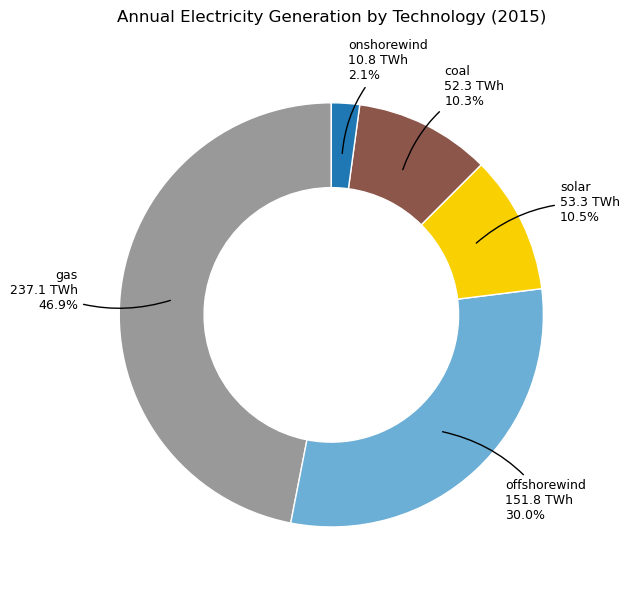

In [147]:
# Data
labels = generation_by_carrier.index
sizes = generation_by_carrier.values

fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts = ax.pie(
    sizes,
    labels=None,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor='white')
)

# Add labels and percentages outside with lines
for i, (wedge, label, value) in enumerate(zip(wedges, labels, sizes)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = np.cos(np.deg2rad(angle))
    y = np.sin(np.deg2rad(angle))
    ha = 'left' if x > 0 else 'right'
    ax.annotate(
        f"{label}\n{value:.1f} TWh\n{value / sizes.sum() * 100:.1f}%",
        xy=(x * 0.75, y * 0.75),
        xytext=(x * 1.2, y * 1.2),
        ha=ha,
        va='center',
        arrowprops=dict(arrowstyle='-', connectionstyle='arc3,rad=0.2'),
        fontsize=9
    )

ax.set_title("Annual Electricity Generation by Technology (2015)", pad=20)
plt.tight_layout()
plt.show()


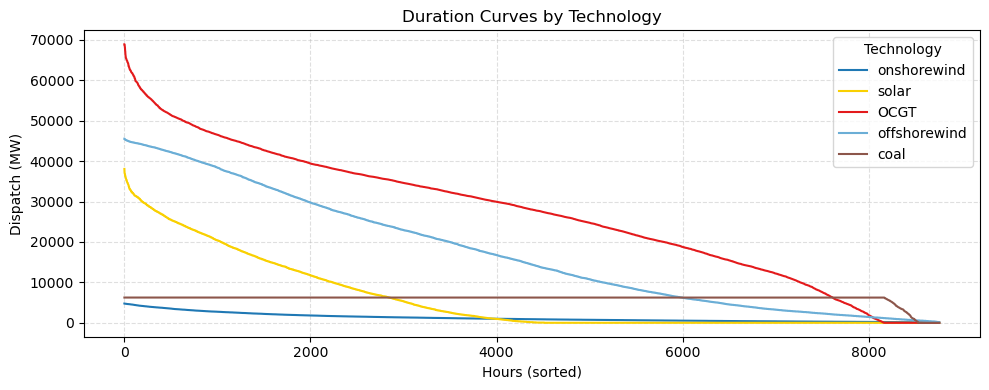

In [148]:
fig, ax = plt.subplots(figsize=(10, 4))

for tech in network.generators_t.p.columns.values:
    if tech=="OCGT":
        tech="gas"
    gen_ids = network.generators.index[network.generators.carrier == tech]
    dispatch = network.generators_t.p[gen_ids].sum(axis=1)
    dispatch_sorted = dispatch.sort_values(ascending=False).reset_index(drop=True)
    if tech=="gas":
        tech="OCGT"
    ax.plot(dispatch_sorted, label=tech, color=color_map.get(tech, "#999999"))

ax.set_title("Duration Curves by Technology")
ax.set_ylabel("Dispatch (MW)")
ax.set_xlabel("Hours (sorted)")
ax.legend(title="Technology")
ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

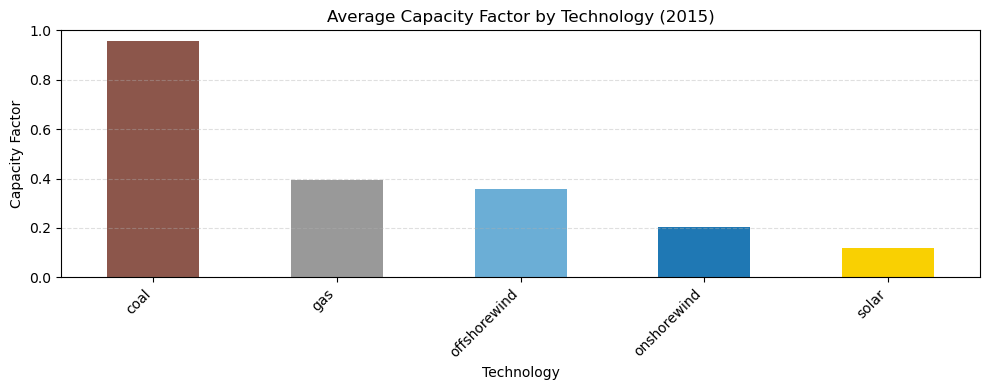

In [151]:
cf = (
    network.generators_t.p.sum()
    / (network.generators.p_nom_opt * 8760)
)

cf_by_carrier = (
    cf.groupby(network.generators.carrier)
    .mean()
    .sort_values(ascending=False)
)

# Plot
colors_cf = [color_map.get(carrier, "#999999") for carrier in cf_by_carrier.index]

fig, ax = plt.subplots(figsize=(10, 4))
cf_by_carrier.plot.bar(ax=ax, color=colors_cf)

ax.set_title("Average Capacity Factor by Technology (2015)")
ax.set_ylabel("Capacity Factor")
ax.set_xlabel("Technology")
plt.xticks(rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## B. Introducing a CO2 contraint
Investigate how sensitive the optimum capacity mix is to the global CO2 constraint. E.g., plot the generation mix as a function of the CO2 constraint that you impose. Search for the CO2 emissions in your country (today or in 1990) and refer to the emissions allowance to that historical data.

## C. Analysis of interannual variability
Investigate how sensitive your results are to the interannual variability of solar and wind generation. Plot the average capacity and variability obtained for every generator using different weather years.

## D. Introducing Storage Technology 
Add some storage technology/ies and investigate how they behave and what their impact is on the optimal system configuration. Discuss what strategies is your system using to balance the renewable generation at different time scales (intraday, seasonal, etc.)


In [ ]:
# add battery

network.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 2 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

## E. Decarbonization
Select one target for decarbonization (i.e., one CO2 allowance limit). What is the CO2 price required to achieve that decarbonization level? Search for information on the existing CO2 tax in your country (if any) and discuss your results.

## F. Introducing ATC
Connect your country with, at least, two neighbouring countries. You can connect them using HVAC lines, HVDC links or gas pipelines. Use a linear representation of power flow or gas flow. 
You can assume that the generation capacities in the neighbouring countries are fixed or optimize the whole system. You can also include fixed interconnection capacities or optimize them with the generators' capacities. Discuss your results.

## G. Sector Coupling 
Connect the electricity sector with, at least, another sector( e.g. heating or transport), and co-optimize all the sectors. Discuss your results.

## H. Investigation of country specific problem 
Finally, select one topic that is under discussion in your region. Design and implement some experiment to obtain relevant information regarding that topic. E.g.

- What are the consequences if Denmark decides not to install more onshore wind?

- Would it be more expensive if France decides to close its nuclear power plants?

- What will be the main impacts of the Viking link?

- How does gas scarcity impact the optimal system configuration?